# Options Chain Column Descriptions

| **Column**          | **Description**                                                                 |
|---------------------|----------------------------------------------------------------------------------|
| `contractSymbol`    | Unique identifier for the option contract (includes ticker, expiration, strike, type). |
| `lastTradeDate`     | Timestamp of the last trade made for that specific option.                      |
| `strike`            | Strike price — the agreed price at which the underlying stock can be bought or sold. |
| `lastOptionPrice`         | Last traded price of the option (may not be current bid/ask).                   |
| `bid`               | Current highest price a buyer is willing to pay for the option.                 |
| `ask`               | Current lowest price a seller is willing to accept for the option.              |
| `change`            | Price change of the option compared to the previous trading day's close.        |
| `percentChange`     | Percentage change in the option's price from the previous close.                |
| `volume`            | Number of option contracts traded during the current trading day.               |
| `openInterest`      | Total number of outstanding option contracts that have not been settled.        |
| `impliedVolatility` | Market's forecast of the stock's future volatility, implied from the option's price. |
| `inTheMoney`        | Boolean — `True` if the option is currently profitable to exercise, else `False`. |
| `contractSize`      | Number of shares per contract (typically 100 for U.S. equity options).          |
| `currency`          | Currency the option is traded in (usually "USD").                               |
| `type`              | `'call'` or `'put'` — you added this manually to distinguish them.              |
| `expiration`        | Expiration date of the option (you also added this manually).                   |


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yfinance as yf
import seaborn as sns
import pandas  as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from FMNM.BS_pricer import BS_pricer
from FMNM.Parameters import Option_param
from FMNM.Processes import Diffusion_process

import scipy.stats as ss
from scipy.integrate import quad
from typing import List, Optional
from scipy.stats import norm
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

from utils.gbm import GBMAnalyzer
from utils.dataFetcher import OptionsDataFetcher as odf

In [3]:
fetcher = odf('TSLA')
stock_data = fetcher.fetch_stock_data("2024-04-18", "2025-05-18")
opts_data = fetcher.fetch_options_chain()
opts_data_p = fetcher.fetch_options_chain(puts_only = True)
opts_data_c = fetcher.fetch_options_chain(calls_only = True)
fetcher.save(stock_data, opts_data, path="retrivedData", save_stock=True, save_options=True)

Stock data saved to: retrivedData/TSLA_stock_data.csv
Options data saved to: retrivedData/TSLA_options_chain.csv


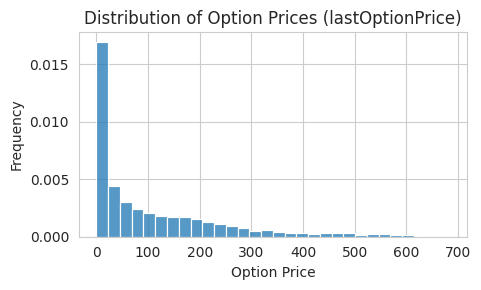

In [4]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 3))
sns.histplot(opts_data['lastOptionPrice'], bins=30, kde=False, edgecolor='white', stat = 'density')
plt.title("Distribution of Option Prices (lastOptionPrice)")
plt.xlabel("Option Price")
plt.ylabel("Frequency")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [5]:
# Calls
fig_calls = px.scatter(
    opts_data_c,
    x='strike',
    y='lastOptionPrice',
    title='Call Options: Strike vs Last Price',
    labels={'strike': 'Strike Price', 'lastOptionPrice': 'Option Price'},
    color_discrete_sequence=['#1f77b4']
)
fig_calls.update_traces(marker=dict(size=6))
fig_calls.update_layout(template='plotly_white')
fig_calls.show()

# Puts
fig_puts = px.scatter(
    opts_data_p,
    x='strike',
    y='lastOptionPrice',
    title='Put Options: Strike vs Last Price',
    labels={'strike': 'Strike Price', 'lastOptionPrice': 'Option Price'},
    color_discrete_sequence=['#d62728']
)
fig_puts.update_traces(marker=dict(size=6))
fig_puts.update_layout(template='plotly_white')
fig_puts.show()

In [6]:
fig = px.scatter(
    opts_data_c,
    x='lastTradeDate',
    y='lastOptionPrice',
    title='Call Options: Last Price vs. Last Trade Date',
    labels={
        'lastTradeDate': 'Last Trade Date',
        'lastOptionsPrice': 'Last Price (USD)'
    },
    template='plotly_white'
)

fig.update_traces(
    marker=dict(size=6, color='skyblue', line=dict(width=1, color='DarkSlateGrey'))
)

fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    title_font_size=20
)

fig.show()

In [7]:
fig = go.Figure()

# Scatter for Strike vs. Last Trade Date
fig.add_trace(go.Scatter(
    x=opts_data_c['lastTradeDate'],
    y=opts_data_c['strike'],
    mode='markers',
    name='Strike Price',
    marker=dict(color='#1f77b4', size=6),
))

# Scatter for Last Price vs. Last Trade Date
fig.add_trace(go.Scatter(
    x=opts_data_c['lastTradeDate'],
    y=opts_data_c['lastOptionPrice'],
    mode='markers',
    name='Last Option Price',
    marker=dict(color='#d62728', size=6),
))

fig.update_layout(
    title='Call Options: Strike & Last Price over Time',
    xaxis_title='Last Trade Date',
    yaxis_title='Price',
    template='plotly_white',
    legend=dict(title="Metrics"),
    height=500
)

fig.show()


In [8]:
fig = go.Figure()

# Strike Price trace (blue)
fig.add_trace(go.Scatter(
    x=opts_data_p['lastTradeDate'],
    y=opts_data_p['strike'],
    mode='markers',
    name='Strike Price',
    marker=dict(color='#1f77b4')
))

# Last Price trace (red)
fig.add_trace(go.Scatter(
    x=opts_data_p['lastTradeDate'],
    y=opts_data_p['lastOptionPrice'],
    mode='markers',
    name='Last Option Price',
    marker=dict(color='#d62728')
))

fig.update_layout(
    title='Put Options: Strike & Last Price over Time',
    xaxis_title='Last Trade Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend_title='Metric',
    height=500
)

fig.show()


In [9]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Close'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Open'], mode='lines', name='Open'))

fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Volume'] / 1e6, mode='lines', name='Volume (millions)'))

fig.update_layout(
    title='Stock Prices and Volume',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_white'
)

fig.show()

In [10]:
def plot_greeks(
    data: pd.DataFrame,
    x_col: Optional[str] = None,
    greeks_to_plot: Optional[List[str]] = None,
    title: Optional[str] = "Option Greeks"
) -> None:

    x = data.index if x_col is None else data[x_col]

    available_greeks = [g for g in ['delta', 'gamma', 'theta', 'vega', 'rho'] if g in data.columns]

    greeks = greeks_to_plot if greeks_to_plot is not None else available_greeks

    fig = go.Figure()

    for greek in greeks:
        if greek in data.columns:
            fig.add_trace(
                go.Scatter(
                    x=x,
                    y=data[greek],
                    mode='lines+markers',
                    name=greek.capitalize()
                )
            )

    fig.update_layout(
        title=title,
        xaxis_title=x_col if x_col else "Index",
        yaxis_title="Value",
        template="plotly_white"
    )

    fig.show()


In [11]:
def S(timestamp):
    return stock_data.loc[timestamp, 'Close']

def profit(t0, t, p):
    St, S0 = S(t), S(t0)
    if St > S0:
        print('call!')
    elif St < S0:
        print('put')
    else:
        print('stable')
    return max(np.abs(St - S0) -p , -p)

In [12]:
analyzer = GBMAnalyzer(stock_data)

start_date = "2024-05-15"
end_date = "2025-05-15"

mean_log, std_log = analyzer.gbm_log_stats(start_date, end_date)
print(f"Expected log-price at {end_date}: {mean_log:.4f}")
print(f"Std dev of log-price: {std_log:.4f}")

ci_low, ci_high = analyzer.confidence_interval(start_date, end_date)
print(f"95% Confidence Interval for Price at {end_date}:")
print(f"Lower Bound: ${ci_low:.2f}")
print(f"Upper Bound: ${ci_high:.2f}")

Expected log-price at 2025-05-15: 5.5873
Std dev of log-price: 0.7146
95% Confidence Interval for Price at 2025-05-15:
Lower Bound: $63.95
Upper Bound: $1114.90


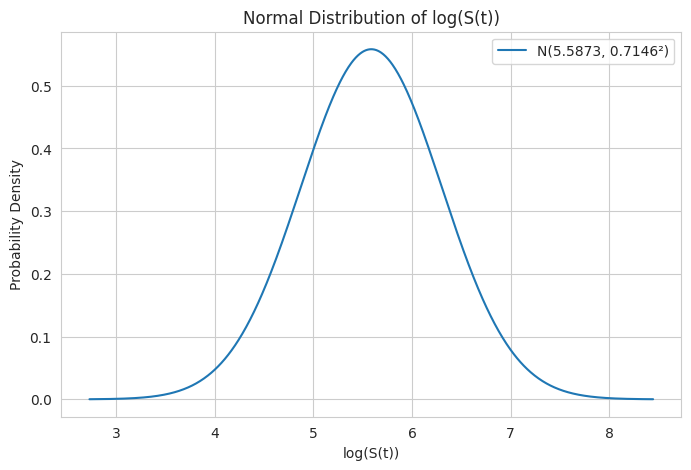

In [13]:
mean, std= mean_log, std_log
x = np.linspace(mean - 4*std, mean + 4*std, 1000)
pdf = norm.pdf(x, loc=mean, scale=std)

plt.figure(figsize=(8,5))
plt.plot(x, pdf, label=f'N({mean:.4f}, {std:.4f}²)')
plt.title('Normal Distribution of log(S(t))')
plt.xlabel('log(S(t))')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()